# Transfer Learning

Transfer learning refers to the process of pre-training a flexible model on a large dataset and using it later on other data with little to no training. It is one of the most outstanding 🚀 achievements in Machine Learning 🧠 and has many practical applications.

For time series forecasting, the technique allows you to get lightning-fast predictions ⚡ bypassing the tradeoff between accuracy and speed (more than 30 times faster than our alreadsy fast [autoARIMA](https://github.com/Nixtla/statsforecast) for a similar accuracy).

This notebook shows how to generate a pre-trained model and store it in a checkpoint to make it available to forecast new time series never seen by the model. 

Table of Contents<br>
1.   Installing NeuralForecast/DatasetsForecast<br>
2.   Load M4 Data<br>
3.   Instantiate NeuralForecast core, Fit, and save<br>
4.   Load pre-trained model and predict on AirPassengers<br>
5.   Evaluate Results<br>

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing Libraries

In [ ]:
# %%capture
# !pip install datasetsforecast neuralforecast

In [ ]:
import logging

import numpy as np
import pandas as pd
import torch
from datasetsforecast.m4 import M4
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.utils import AirPassengersDF
from utilsforecast.losses import mae
from utilsforecast.plotting import plot_series

In [ ]:
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

This example will automatically run on GPUs if available. **Make sure** cuda is available. (If you need help to put this into production send us an email or join or community, we also offer a fully hosted solution)

In [ ]:
torch.cuda.is_available()

True

## 2. Load M4 Data

The `M4` class will automatically download the complete M4 dataset and process it.

It return three Dataframes: `Y_df` contains the values for the target variables, `X_df` contains exogenous calendar features and `S_df` contains static features for each time-series (none for M4). For this example we will only use `Y_df`.

If you want to use your own data just replace `Y_df`. Be sure to use a long format and have a simmilar structure than our data set.

In [ ]:
Y_df, _, _ = M4.load(directory='./', group='Monthly', cache=True)
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df

,unique_id,ds,y
0,M1,1970-01-01 00:00:00.000000001,8000.0
1,M1,1970-01-01 00:00:00.000000002,8350.0
2,M1,1970-01-01 00:00:00.000000003,8570.0
3,M1,1970-01-01 00:00:00.000000004,7700.0
4,M1,1970-01-01 00:00:00.000000005,7080.0
...,...,...,...
11246406,M9999,1970-01-01 00:00:00.000000083,4200.0
11246407,M9999,1970-01-01 00:00:00.000000084,4300.0
11246408,M9999,1970-01-01 00:00:00.000000085,3800.0
11246409,M9999,1970-01-01 00:00:00.000000086,4400.0


## 3. Model Train and Save

Using the `NeuralForecast.fit` method you can train a set of models to your dataset. You just have to define the `input_size` and `horizon` of your model. The `input_size` is the number of historic observations (lags) that the model will use to learn to predict `h` steps in the future. Also, you can modify the hyperparameters of the model to get a better accuracy.

In [ ]:
horizon = 12
stacks = 3
models = [NHITS(input_size=5 * horizon,
                h=horizon,
                max_steps=100,
                stack_types = stacks*['identity'],
                n_blocks = stacks*[1],
                mlp_units = [[256,256] for _ in range(stacks)],
                n_pool_kernel_size = stacks*[1],
                batch_size = 32,
                scaler_type='standard',
                n_freq_downsample=[12,4,1],
                enable_progress_bar=False
               )]
nf = NeuralForecast(models=models, freq='ME')
nf.fit(df=Y_df)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Save model with `core.NeuralForecast.save` method. This method uses PytorchLightning `save_checkpoint` function. We set `save_dataset=False` to only save the model.

In [ ]:
nf.save(path='./results/transfer/', model_index=None, overwrite=True, save_dataset=False)

## 4. Transfer M4 to AirPassengers

We load the stored model with the `core.NeuralForecast.load` method, and forecast `AirPassenger` with the `core.NeuralForecast.predict` function.

In [ ]:
fcst2 = NeuralForecast.load(path='./results/transfer/')

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
# We define the train df. 
Y_df = AirPassengersDF.copy()
mean = Y_df[Y_df.ds<='1959-12-31']['y'].mean()
std = Y_df[Y_df.ds<='1959-12-31']['y'].std()

Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test

In [ ]:
Y_hat_df = fcst2.predict(df=Y_train_df)
Y_hat_df.head()

,unique_id,ds,NHITS
0,1.0,1960-01-31,416.846130
1,1.0,1960-02-29,396.173950
2,1.0,1960-03-31,452.131226
3,1.0,1960-04-30,459.571442
4,1.0,1960-05-31,464.970917


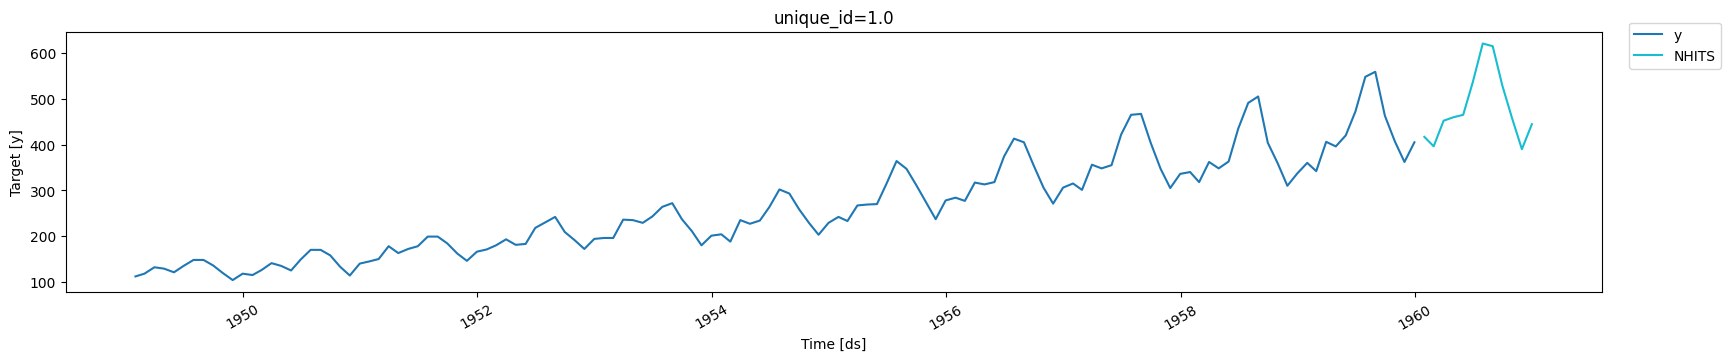

In [ ]:
plot_series(Y_train_df, Y_hat_df)

## 5. Evaluate Results


We evaluate the forecasts of the pre-trained model with the Mean Absolute Error (`mae`).

$$
\qquad MAE = \frac{1}{Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}|\qquad
$$

In [ ]:
fcst_mae = mae(Y_test_df.merge(Y_hat_df), models=['NHITS'])['NHITS'].item()
print(f'NHITS     MAE: {fcst_mae:.3f}')
print('ETS       MAE: 16.222')
print('AutoARIMA MAE: 18.551')

NHITS     MAE: 8.065
ETS       MAE: 16.222
AutoARIMA MAE: 18.551
